# Perform Blur Detection with OpenCV
### This is the definition of the problem and not the solution.

In [1]:
# open cv packege
import cv2
from cv2 import IMREAD_COLOR,IMREAD_UNCHANGED

# useful packeges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# statistic packeges
from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize
%matplotlib inline

### Image Exploration using Laplacian Matrix

The Laplace filter is mainly used to define the edge lines in a picture. What is meant here by the edge are the sharp color separations that usually separate objects from the background

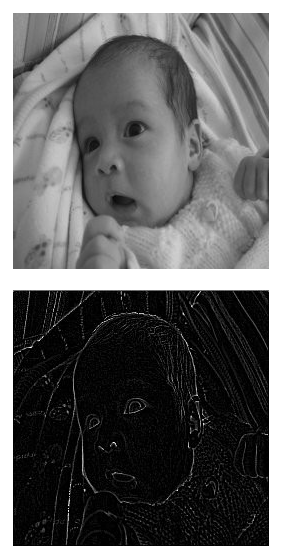

You simply take a single channel of an image (presumably grayscale) and convolve it with the following 3 x 3 kernel:



And then take the variance (i.e. standard deviation squared) of the response.

If the variance falls below a pre-defined threshold, then the image is considered blurry; otherwise, the image is not blurry.

In [2]:
def variance_of_laplacian(img2):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    gray = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def BGR2RGB(BGR_img):
    # turning BGR pixel color to RGB
    rgb_image = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
    return rgb_image
    

    

In [3]:
def blurrinesDetection(directories,threshold):
    columns = 3
    rows = len(directories)//2
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i,directory in enumerate(directories):
        fig.add_subplot(rows, columns, i+1)
        img = cv2.imread(directory)
        text = "Not Blurry"
        # if the focus measure is less than the supplied threshold,
        # then the image should be considered "blurry
        fm = variance_of_laplacian(img)
        if fm < threshold:
            text = "Blurry"
        rgb_img = BGR2RGB(img)
        cv2.putText(rgb_img, "{}: {:.2f}".format(text, fm), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        plt.imshow(rgb_img)
    plt.show()
    
    
    

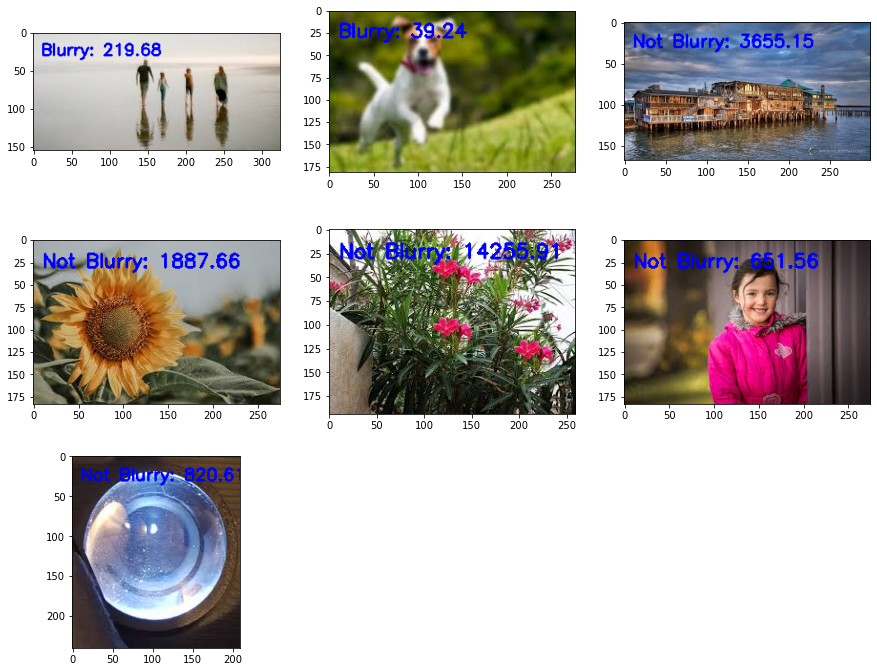

In [4]:
directories = ['../input/imageimage/img{}.jpeg'.format(i) for i in range(1,8)]
blurrinesDetection(directories,300)

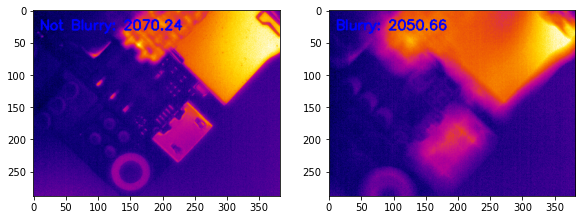

In [5]:
directories2 = ['../input/imageimage/img{}.png'.format(i) for i in range(8,10)]
blurrinesDetection(directories2,2060)

The basic approach is this:
use Laplace (or Sobel) filter to find edges in the input image
compute the variance and the maximum over the pixel values of the filtered image
high variance (and a high maximum) suggest clearly distinguished edges, i.e. a sharp image. Low variance suggests a blurred image


### Data Preperation for ML Solution

In [6]:
from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize

def laplaceEdgeVariance(path):
    # Load image
    img = cv2.imread(path)

    # Resize image
    img = resize(img, (400, 600))
    
    # Gray-Scale change
    img = rgb2gray(img)

    # Edge detection
    edge_laplace = laplace(img, ksize=3)
    
    return [variance(edge_laplace),np.amax(edge_laplace)]

In [7]:
directories.extend(directories2)
directories

['../input/imageimage/img1.jpeg',
 '../input/imageimage/img2.jpeg',
 '../input/imageimage/img3.jpeg',
 '../input/imageimage/img4.jpeg',
 '../input/imageimage/img5.jpeg',
 '../input/imageimage/img6.jpeg',
 '../input/imageimage/img7.jpeg',
 '../input/imageimage/img8.png',
 '../input/imageimage/img9.png']

In [8]:
humen_detection_of_blurriness = [1,1,0,0,0,0,0,0,1]
Thermal = [0,0,0,0,0,0,0,1,1]
df = pd.DataFrame(list(zip(directories, humen_detection_of_blurriness,Thermal)), 
               columns =['Directory', 'Vision Mode','Thermal'])
df['Vision Mode'].replace({0:'Sharp',1:'Blurry'},inplace=True)
df['Thermal'].replace({0:'No',1:'Yes'},inplace=True)
df

,Directory,Vision Mode,Thermal
0,../input/imageimage/img1.jpeg,Blurry,No
1,../input/imageimage/img2.jpeg,Blurry,No
2,../input/imageimage/img3.jpeg,Sharp,No
3,../input/imageimage/img4.jpeg,Sharp,No
4,../input/imageimage/img5.jpeg,Sharp,No
5,../input/imageimage/img6.jpeg,Sharp,No
6,../input/imageimage/img7.jpeg,Sharp,No
7,../input/imageimage/img8.png,Sharp,Yes
8,../input/imageimage/img9.png,Blurry,Yes


In [9]:
def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

df = apply_and_concat(df,'Directory',laplaceEdgeVariance,['Variance(Laplace)','Maximum(Laplace)'])
df

,Directory,Vision Mode,Thermal,Variance(Laplace),Maximum(Laplace)
0,../input/imageimage/img1.jpeg,Blurry,No,0.000261,0.378988
1,../input/imageimage/img2.jpeg,Blurry,No,0.000029,0.072730
2,../input/imageimage/img3.jpeg,Sharp,No,0.002447,0.458943
3,../input/imageimage/img4.jpeg,Sharp,No,0.001164,0.569854
4,../input/imageimage/img5.jpeg,Sharp,No,0.008961,1.001340
5,../input/imageimage/img6.jpeg,Sharp,No,0.000384,0.446977
6,../input/imageimage/img7.jpeg,Sharp,No,0.000882,0.487662
7,../input/imageimage/img8.png,Sharp,Yes,0.001029,0.269812
8,../input/imageimage/img9.png,Blurry,Yes,0.001011,0.274357


What is the right threshold to distinguish sharp from blurry images (based on the computed values)?

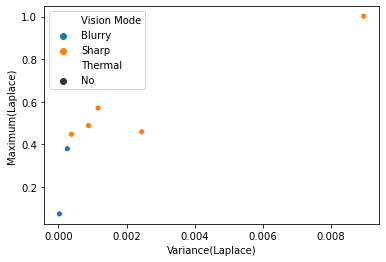

In [10]:
sns.scatterplot(x = 'Variance(Laplace)', y = 'Maximum(Laplace)', hue='Vision Mode', data=df[df.Thermal == 'No'], style ='Thermal')

In [11]:
Thermal_df = df[df.Thermal == 'Yes']
Thermal_df

,Directory,Vision Mode,Thermal,Variance(Laplace),Maximum(Laplace)
7,../input/imageimage/img8.png,Sharp,Yes,0.001029,0.269812
8,../input/imageimage/img9.png,Blurry,Yes,0.001011,0.274357


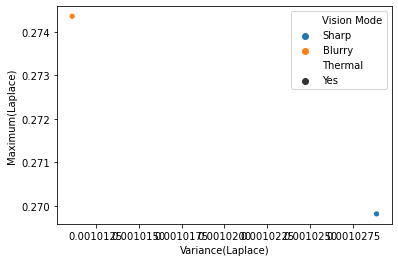

In [12]:
sns.scatterplot(x = 'Variance(Laplace)', y = 'Maximum(Laplace)', hue='Vision Mode', data=Thermal_df, style ='Thermal')

### Sources

* Laplacian matrix(wiki) - https://en.wikipedia.org/wiki/Laplacian_matrix
* Laplace computing - https://www.youtube.com/watch?v=rVnOANM0oJE
* Blurriness prediction - https://medium.com/snapaddy-tech-blog/mobile-image-blur-detection-with-machine-learning-c0b703eab7de 
* Blur detection - https://www.analyticsvidhya.com/blog/2020/09/how-to-perform-blur-detection-using-opencv-in-python/